Goal: Predict whether a game will sell more than 1 million copies globally (Global_Sales > 1.0)

In [2]:
#We set up our scikit learn libraries and clean our data similarly like in our EDA file.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score


GITHUB_RAW = "https://raw.githubusercontent.com/mjg377/Video-Game-Sales-on-a-Global-Scale/main/data/vgsales.csv"
df = pd.read_csv(GITHUB_RAW)

df=df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df['Publisher'] = df ['Publisher'].fillna('Unknown')

df['hit_sales']=(df['Global_Sales'] > 1.0).astype(int)

In [3]:
#We now select our attributes where we will closely analysis which is platforms, genre, and year

features = ['Platform','Genre','Year']
X= df[features]
y=df['hit_sales']

In [7]:
#We now create a train/test split

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2860
           1       0.63      0.12      0.20       406

    accuracy                           0.88      3266
   macro avg       0.76      0.55      0.57      3266
weighted avg       0.86      0.88      0.84      3266

ROC-AUC: 0.697475369458128


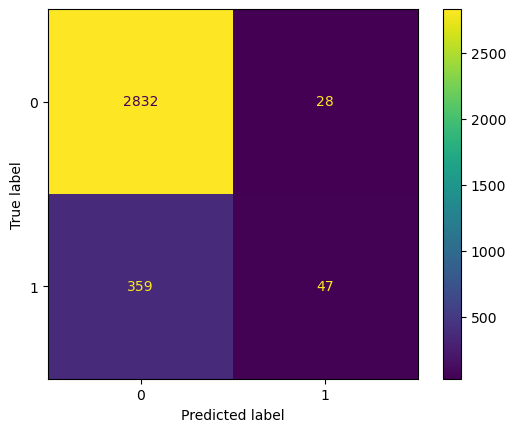

In [11]:
#We now prepate the preprocessing and model pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
preprocessor=ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'),['Platform','Genre']),
        ('num','passthrough', ['Year'])
    ]
)
model=Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))])
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred))
print("ROC-AUC:", roc_auc_score(y_test,y_proba))

cm=confustion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()
    
     
#This confusion matrix plots, shows how correctly predicted the non-hit games were, but unfortunately, had several missed 'hit-games' (359)

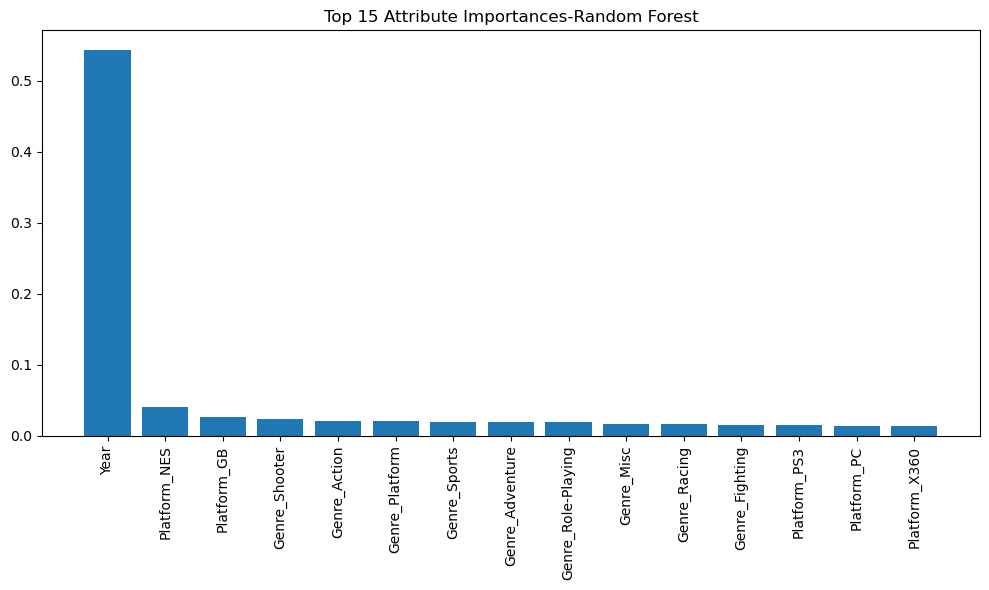

In [19]:
import numpy as np
feature_names= (
    model.named_steps['prep']
        .named_transformers_['cat']
        .get_feature_names_out(['Platform','Genre'])
)

#We now combine categorical and numeric attributes

all_features = list(feature_names) + ['Year']
importances = model.named_steps['clf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(15), importances[indices][:15])
plt.xticks(range(15),[all_features[i] for i in indices[:15]], rotation=90)
plt.title("Top 15 Attribute Importances-Random Forest")
plt.tight_layout()
plt.show()

In [23]:
#arget = is_hit used for if the video game is a hit 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# create target
df['is_hit'] = (df['Global_Sales'] > 1.0).astype(int)

#attributes
cat_cols = ['Platform','Genre']
num_cols = ['Year']

X = df[cat_cols + num_cols].fillna('Unknown')
y = df['is_hit']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# preprocessing + model pipeline
preprocessor = ColumnTransformer([
    ('cats', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
], remainder='passthrough')

pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

##Important to note, while the accurancy of this random forest is accurate (88%) due to the 'non-hit' games, the recall which measures the acutal 'hit-games', is only at 12%
#In order to potentially fix this I need to look more into balancing certain classes and fine-tuning thresholds and also looking into logistic regresion

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2860
           1       0.59      0.12      0.19       406

    accuracy                           0.88      3266
   macro avg       0.74      0.55      0.56      3266
weighted avg       0.85      0.88      0.84      3266

ROC-AUC: 0.6958877329566986


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Reused your preprocessor from before (preprocessor)
# we also utilized lr as logistic regression and rf as random forest with the edited estimator samples and class weight balanced.
lr = Pipeline([('prep', preprocessor),
               ('clf', LogisticRegression(max_iter=2000, class_weight='balanced'))])

rf = Pipeline([('prep', preprocessor),
               ('clf', RandomForestClassifier(n_estimators=400, max_depth=None,
                                             class_weight='balanced', random_state=42))])

for name, model in [('LR', lr), ('RF', rf)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


C:\Users\marti\New Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LR
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      2860
           1       0.19      0.67      0.30       406

    accuracy                           0.61      3266
   macro avg       0.56      0.64      0.52      3266
weighted avg       0.84      0.61      0.68      3266

ROC-AUC: 0.6979219056805264

RF
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2860
           1       0.22      0.54      0.31       406

    accuracy                           0.70      3266
   macro avg       0.57      0.63      0.56      3266
weighted avg       0.83      0.70      0.74      3266

ROC-AUC: 0.68326802507837


C:\Users\marti\New Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LR
              precision    recall  f1-score   support

           0       0.93      0.60      0.73      2860
           1       0.19      0.67      0.30       406

    accuracy                           0.61      3266
   macro avg       0.56      0.64      0.52      3266
weighted avg       0.84      0.61      0.68      3266

ROC-AUC: 0.6979219056805264

RF
              precision    recall  f1-score   support

           0       0.92      0.72      0.81      2860
           1       0.22      0.54      0.31       406

    accuracy                           0.70      3266
   macro avg       0.57      0.63      0.56      3266
weighted avg       0.83      0.70      0.74      3266

ROC-AUC: 0.68326802507837


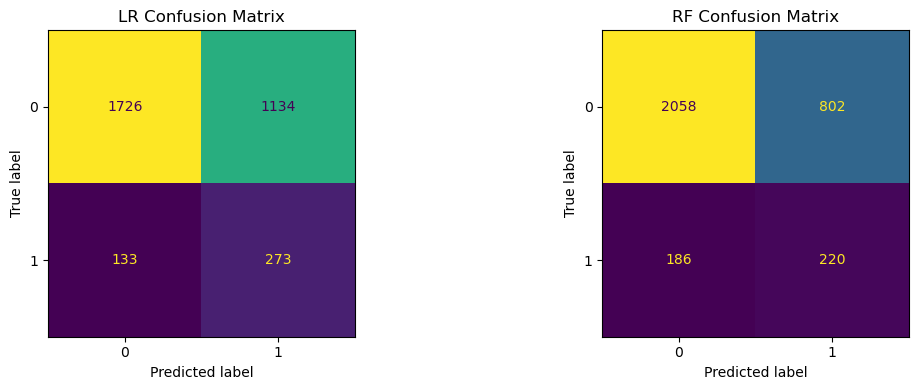

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

results = []

for name, model in [('LR', lr), ('RF', rf)]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))


    cm = confusion_matrix(y_test, y_pred)
    results.append((name, cm))

# Confusion Matrix Plot
fig, axes = plt.subplots(1, len(results), figsize=(12,4))
for ax, (name, cm) in zip(axes, results):
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{name} Confusion Matrix")
plt.tight_layout()
plt.show()

#Here we can visually see how the logistic model has more false positives when compared to true positive from the first random forest model
#The logistic regression has also improved recall but with a lesser precision and accuracy.

#The modified random forest that had the balaced attribute weight and sample had a much more overall balanced correlation, which may make this the best model to use out of the three presented. 